# **PyTorch Example**
#### 이 파일은 "stockait" 라이브러리를 사용하여 주가 데이터에 대한 딥러닝 모델링 예시를 보여준다. 그 중에서도 **pytorch** 프레임워크를 사용하는 튜토리얼이다. 

<br> 


In [1]:
import sys
sys.path.append("/project/stockAI/github/main/stockait")
import stockait as sai
import pandas as pd

import torch
import torch.nn as nn

import numpy as np

--------

<br> 
<br> 

# 1. **Load Data**

#### 데이터 로드 및 전처리 과정은 생략하고, `00.demo.ipynb` 파일 에서 저장한 데이터로 연구를 진행한다.  
#### 데이터는 다음의 두 가지가 존재한다. 
- time_series_0903.parquet 
- time_series_0903_scaled.parquet (스케일링 적용 데이터 / div-close 방법) 

#### 스케일링을 제외하고는 모두 같은 방법으로 전처리가 적용되어있다. 

In [2]:
df_time_series = pd.read_parquet("time_series_0903.parquet") 
df_time_series_scaled = pd.read_parquet("time_series_0903_scaled.parquet")

df_time_series['Code'] = df_time_series['Code'].astype(str).str.zfill(6)
df_time_series_scaled['Code'] = df_time_series_scaled['Code'].astype(str).str.zfill(6)

In [ ]:
print(df_time_series.shape) 
df_time_series.head()

#### 날짜는 2017년 1월 1일 부터 2021년 12월 31일까지이며, 총 42개의 보조지표를 추가한 데이터이다. 또한 하나의 행에는 10일치의 주가 데이터, 보조지표 컬럼이 존재한다. Code, Date, next_change(종속변수)를 제외하고, 총 480개의 독립변수를 가지는 것을 볼 수 있다.   

In [3]:
data = df_time_series # Data Before Scaling
data_scaled = df_time_series_scaled # Data After Scaling

# train, validation, test dataset split
train_data = data[(data['Date'] >= '2017-01-01') & (data['Date'] <= '2020-12-31')]
valid_data = data[(data['Date'] >= '2021-01-01') & (data['Date'] <= '2021-06-31')] 
test_data = data[(data['Date'] >= '2021-07-01') & (data['Date'] <= '2021-12-31')]

# train, validation, test dataset split (scaled) 
train_data_scaled = data_scaled[(data_scaled['Date'] >= '2017-01-01') & (data_scaled['Date'] <= '2020-12-31')]
valid_data_scaled = data_scaled[(data_scaled['Date'] >= '2021-01-01') & (data_scaled['Date'] <= '2021-06-31')] 
test_data_scaled = data_scaled[(data_scaled['Date'] >= '2021-07-01') & (data_scaled['Date'] <= '2021-12-31')]

print(train_data.shape, valid_data.shape, test_data.shape)
print(train_data_scaled.shape, valid_data_scaled.shape, test_data_scaled.shape)

(828290, 483) (107068, 483) (110091, 483)
(828290, 483) (107068, 483) (110091, 483)


#### 2017년 부터 2020년을 학습 데이터셋으로, 2021년 6월까지 검증 데이터셋, 2021년 12월까지 시험 데이터셋으로 설정하여 분할했다. 

<br> 
<br> 

# **2 Trader Definition**

#### pytorch 프레임워크를 사용하여 딥러닝 모델을 포함하는 트레이더를 정의한다. 이 tutorial에서는 LSTM과 Transformer 모델을 사용하여 주가 빅데이터 연구를 진행한다. 

In [21]:
lst_trader = [] 

<br> 

### **device 설정**
#### 아래에서 trader 객체의 device 속성에 넣어주기 위해 device를 설정한다. 

In [7]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<br> 

## **1) LSTM** 
#### 간편하게 하나의 셀에 트레이더를 간편하게 정의해줄 수 있는 것이 "stockAIT"의 장점 중 하나이다. 하지만 이번 tutorial에서는 더 쉬운 이해를 위해 여러개의 셀로 나누어 진행하겠다.

### **ConditionalBuyer 객체와 sampling 함수 정의** 
#### ConditionalBuyer에서 주가 데이터를 필터링 할 조건을 설정하는 함수 sampling을 직접 정의한다. 종가 변화율이 30% 이상이면 제외하며, 종가 변화율이 너무 낮은 -0.05 ~ 0.05 인 데이터는 제외하고, 거래대금이 10억 이상인 데이터셋만을 사용하도록 조건을 생성했다. 

In [22]:
b1_lspt = sai.ConditionalBuyer()

def sampling5(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3)
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition4 = (df.D0_CCI <= -100)
    condition = condition1 & condition2 & condition3 & condition4
    return condition

b1_lspt.condition = sampling5

### **MachinelearnigBuyer 객체 정의** 
#### Machinelearning Buyer는 인공지능 모델 학습을 담당한다. 인공지능 모델과 관련된 정보들은 모두 Machinelearning Buyer 객체의 속성에 넣어줘야 한다. 

In [22]:
b2_lspt = sai.MachinelearningBuyer()

#### 첫번째로, 데이터를 3차원으로 변환해주는 함수를 저장하는 **data_transform** 속성이다. 

### **transform 함수 정의** 
#### 아래의 그림을 보면, 현재 우리가 갖고 있는 주가 데이터의 모양이 왼쪽에 나와있다. 
#### 원래 데이터의 shape은 **(828290, 483)** 이었다. 이를 딥러닝 모델에 넣어주기 위하여 3차원 shape으로 변환해야한다. 

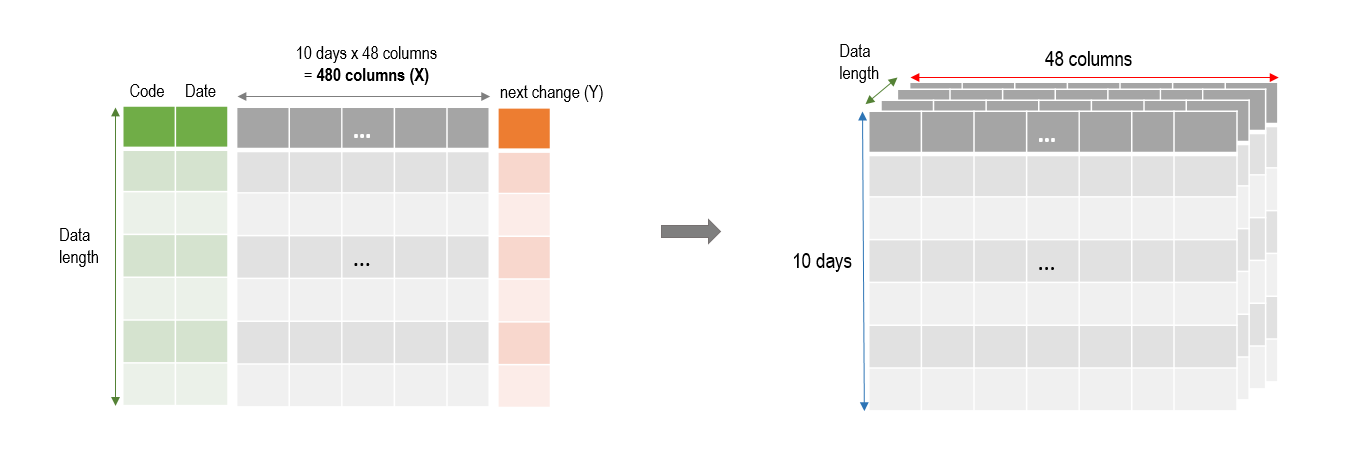

#### 즉, 하나의 행에 총 **10일 x 48개 컬럼 = 480개의 컬럼** 으로 이루어져있던 종속변수를 (data_length, sequence_length, dimension) 으로 변환하여 3차원인 **(828290, 10, 48)** 의 shape으로 만들어주는 작업이다. 

In [22]:
# User-defined functions (users who want deep learning modeling)
def transform(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_lspt.data_transform = transform 

#### 3차원 데이터로 변환하는 함수를 정의했으면, data_transform 속성에 추가해준다.  
#### 그 다음으로는 Machinelearning Buyer 객체의 핵심인 딥러닝 모델을 정의한다. 

### **프레임워크 및 device 설정** 
#### 먼저, framework 속성에 pytorch 프레임워크를 사용함을 명시한다. 
#### keras와 달리 pytorch 사용 시에는 device 속성에 위에서 정의한 device를 정의해주어야 한다. 연산을 하는 데이터, 모델은 모두 같은 device에서 동작해야하기 때문에 트레이더 내부에 저장한다. 

In [22]:
# framework  
b2_lspt.framework = "pytorch"

# devcice  
b2_lspt.device = device 

### **딥러닝 모델 정의**
#### pytorch 프레임워크를 사용하여 LSTM 모델을 정의한다. 
#### 모델 객체를 생성하고, 생성된 모델 객체를 algorithm 속성에 넣는다. 

In [22]:
##### LSTM Model Definition #####
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # hidden state와 cell state의 값을 0으로 초기화 함 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # hidden state 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # cell state 
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        # out = torch.sigmoid(out) 
                      
        return out

# create a model 
input_size, hidden_size, num_layers, output_size = 48, 64, 32, 1 
model = LSTM(input_size, hidden_size, num_layers, output_size)   

b2_lspt.algorithm = model

### **하이퍼 파라미터 & 손실함수 & optimizer 정의** 
#### 그 다음 `parms` 속성에 dictionary 형태로 하이퍼 파라미터 (에폭과 배치 사이즈) 를 넣어준다. 
#### optim 속성에는 손실함수와 옵티마이저를 dictionary 형태로 입력한다. 
#### 우리는 다음날 종가가 2% 이상 올랐는지를 예측하는 이진분류 모델을 생성해야하므로, 마지막 층은 1개의 유닛으로 설계했으며, sigmoid 함수는 적용하지 않았다. 따라서 손실함수는 sigmoid 함수 연산을 포함하는 BCEWithLogitsLoss를 사용한다. 데이터 불균형으로 인해 pos_weight으로 클래스 1에 가중치를 주었다.  

In [22]:
# hyper parameters for model fitting 
b2_lspt.params = {
    "epochs": 20, 
    "batch_size": 64,
    }
                      
# learning rate & pos weight  
learning_rate = 0.001 
pos_weight = torch.tensor([4.0], device=device)

# loss function & optimizer 
b2_lspt.optim = {
    "criterion": nn.BCEWithLogitsLoss(pos_weight=pos_weight), 
    "optimizer": torch.optim.Adam(model.parameters(), lr=learning_rate)  
    }

#### 이로써 Buyer 의 서브 객체들인 Conditional Buyer와 Machinelearning Buyer를 모두 정의해주었고, 이번에는 Seller의 서브 객체인 SubSeller를 정의한다. 
### **SubSeller 객체 정의** 
#### SubSeller 객체는 매수한 주식을 매수 날짜 다음날에 모두 되파는 방법만을 제공하고있다. 이러한 SubSeller 객체를 하나 생성해준다. 

In [22]:
sell_all = sai.SubSeller() 

#### 이제 트레이더를 정의할 준비를 모두 끝마쳤다. 

### **트레이더 / Buyer / Seller 객체 정의** 
#### 트레이더 객체에는 트레이더를 구분하기 위한 `name` 속성, 종속변수를 설정하는 `label` 속성, Buyer, Seller 객체를 저장하는 `buyer` 속성과 `seller` 속성이 있다. 

In [22]:
t5 = sai.Trader()
t5.name = 'saiLSTM_pt' 
t5.label = 'class&0.02' 
t5.buyer = sai.Buyer([b1_lspt, b2_lspt]) 
t5.seller = sai.Seller(sell_all)

lst_trader.append(t5)

#### 여기서 label을 보면, "class&0.02"라고 작성되어있는데, **classification** 문제이며, **다음날 종가 변화율**이 **0.02** 이상이면 1, 그렇지 않으면 0으로 이진분류한다는 뜻이다. 분류로 하고싶지 않으면 "reg"라고 설정하여, 다음날 종가 변화율 (next_change) 자체를 종속변수로 사용할 수 있다. 
#### buyer에는 Buyer 객체를 호출할 때 리스트 안에 위에서 정의했던 conditional buyer와 machinelearning buyer를 넣고, seller는 바로 SubSeller 객체를 넣어준다. 

<br> 

### 지금까지 pytorch 프레임워크로 LSTM 모델을 포함한 트레이더를 정의했다. 아래에는 Transformer 모델링을 진행한다.  

<br> 

## **2) Transformer**
#### Transformer는 하나의 셀에 작성하였으며, 위의 LSTM 과 모든 방법이 동일하다. 다른 점은 `algorithm` 속성에 들어가는 모델의 구조 뿐이다. 

In [30]:
import torch
import torch.nn as nn

from tensorflow import keras
import numpy as np

import math 


b1_trpt = sai.ConditionalBuyer()

def sampling5(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 100000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3
    return condition

b1_trpt.condition = sampling5


b2_trpt = sai.MachinelearningBuyer()

# ⭐ User-defined functions (users who want deep learning modeling)
def transform(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_trpt.data_transform = transform 

# franewirj 
b2_trpt.framework = "pytorch"

# devcice  
b2_trpt.device = device 

##### Transformer Model Definition #####
# Positional Encoding 
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# d_model: 차원의 수
    
# Transformer model     
class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, nhid, nlayers):
        super(TransformerModel, self).__init__() 
        self.d_model = d_model 
        self.nhead = nhead 
        self.nhid = nhid 
        self.nlayers = nlayers 
        
        # 임베딩층은 생략 
        # self.emb = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model) 
        self.transformer = nn.Transformer(
                                          d_model, 
                                          nhead,
                                          num_encoder_layers=nlayers,
                                          # num_decoder_layers=nlayers, # 디코더는 생략함 
                                          dim_feedforward=nhid,
                                          )
        
        self.fc  = nn.Linear(d_model, 1)
    
    
    def forward(self, src, pad_id=0):
        x = self.pe(src)
        # mask = (src == pad_id)
        # (S, N, E) 사이즈를 기대 => N: 배치 사이즈, S: 시퀀스 길이 / (N, 10(S), 48) 
        memory = self.transformer.encoder(x.transpose(0, 1),  
                                         # src_key_padding_mask = mask
                                         ) 
        
        
        # 특성 벡터로 변환 (average pooling)
        pooled_memory = memory.mean(dim=0)
        
        # 특성 벡터를 이진 분류 수행 
        out = self.fc(pooled_memory)
        # out = self.fc(memory) 
        out = torch.sigmoid(out) 
        return out 
        
    
                      
# learning rate 
learning_rate = 0.01 

# create a model 
d_model, nhead, nhid, nlayers = 48, 6, 2048, 6 
model = TransformerModel(d_model, nhead, nhid, nlayers)   

b2_trpt.algorithm = model


# hyper parameters for model fitting 
b2_trpt.params = {
    "epochs": 200, 
    "batch_size": 64,
    }

# loss function & optimizer 
b2_trpt.optim = {
    "criterion": nn.BCELoss(), 
    "optimizer": torch.optim.Adam(model.parameters(), lr=learning_rate)  
    }


sell_all = sai.SubSeller() 


t7 = sai.Trader()
t7.name = 'saiTransformer_pt' 
t7.label = 'class&0.02' 
t7.buyer = sai.Buyer([b1_trpt, b2_trpt]) 
t7.seller = sai.Seller(sell_all)

lst_trader.append(t7)

<br>

### 위의 과정을 모두 거치면, lst_trader 안에 트레이더들이 들어가게 되고, 모델 학습 파트 함수의 인자에는 lst_trader를 넣어주어 각 trader 단위로 연산을 수행하게 된다. 

<br> 
<br> 

# **3. Trader(Model) Fitting & Evauation**

## **1) Save Dataset to Traders** 

#### lst_trader와 데이터 (original / scaled 데이터셋의 train / valid / test 데이터셋) 를 인자에 넣어주면 각 트레이더 내부에 데이터셋이 저장된다. 
#### (이 때, scaled 데이터셋과 valid 데이터셋은 필수가 아님.)

In [ ]:
Stores the dataset in the trader.

In [23]:
sai.save_dataset(lst_trader, train_data, valid_data, test_data, train_data_scaled, valid_data_scaled, test_data_scaled)

== saiLSTM_pt ==
== train_code_date: (828290, 2), valid_code_data: (107068, 2), test_code_date: (110091, 2) ==
== trainX: (828290, 480), validX: (107068, 480), testX: (110091, 480) ==
== trainX_scaled: (828290, 480), validX_scaled: (107068, 480), testX_scaled: (110091, 480) ==
== trainY: (828290,), validY: (107068,), testY: (110091,) ==
== trainY_classification: (828290,), validY_classification: (107068,), testY_classification: (110091,) ==



<br> 

## **2) Model fitting**

#### 각각의 트레이더 별로 모델 학습을 진행한다. 
#### `history=True` 로 설정하면, 학습과 더불어 validation 데이터셋 평가가 함께 진행되며, 아래에서 history와 학습 곡선을 그릴 수 있다. 

In [24]:
sai.trader_train(lst_trader, history=True) 

Epoch [5/20]: train loss: 1.2721, train accuracy: 0.3310, valid loss: 1.2732, valid accuracy: 0.3313


Epoch [10/20]: train loss: 1.2731, train accuracy: 0.3318, valid loss: 1.2718, valid accuracy: 0.3311


Epoch [15/20]: train loss: 1.2728, train accuracy: 0.3315, valid loss: 1.2724, valid accuracy: 0.3315


Epoch [20/20]: train loss: 1.2725, train accuracy: 0.3311, valid loss: 1.2720, valid accuracy: 0.3310
== saiLSTM_pt Model Fitting Completed ==


<br> 

## **3) get history & learning Curve** 
#### history=True로 했을 때 이용 가능한 함수이다. history dictionary가 리턴되며, 동시에 학습 곡선 그래프를 출력한다. 

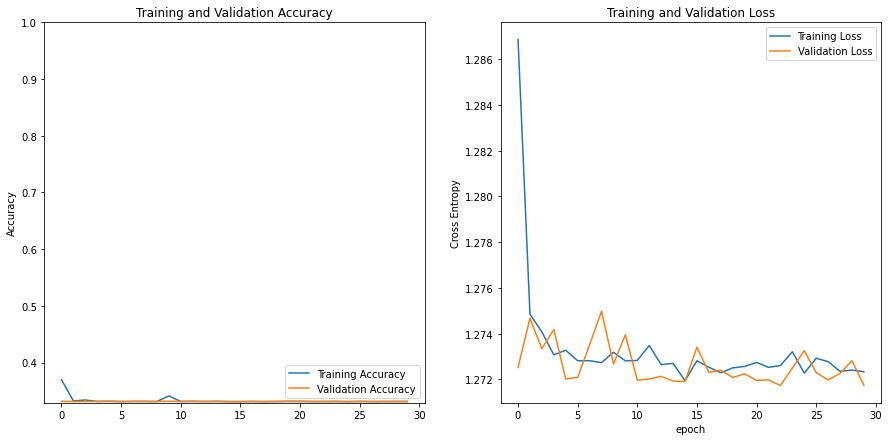

In [11]:
history = sai.get_history_learning_curve(lst_trader)

<br> 

## **4) Model evaluation and threshold settings**
### **Model evaluation**
#### 각각의 트레이더 별로 임계값 마다의 평가지표를 시각화 한다.  

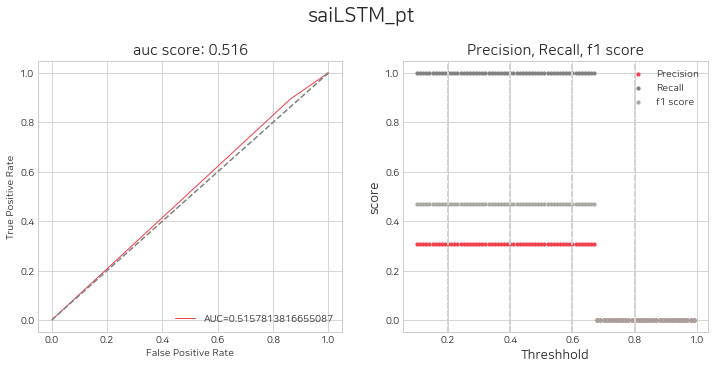

In [12]:
sai.get_eval_by_threshold(lst_trader)

### **threshold settings**
#### 위에서 평가지표 시각화를 토대로 주식을 매수 할 예측 확률 임계값을 설정한다. 
#### histogram=True로 설정하면 validation 데이터셋으로 얼마큼의 수익을 얻을 수 있을지 검증하는 histogram이 함께 출력된다. lst_threshold 인자에 임계값을 바꿔보며 검증된 수익성으로 임계값을 판단할 수 있다. 
#### 아래의 그래프를 예로 들어 임계값이 0.5 라면, 예측 확률이 0.5 이상인 데이터들의 다음 날 종가 변화율의 평균이 0.571 이므로 0.571 만큼의 수익률을 기대할 수 있다.  

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

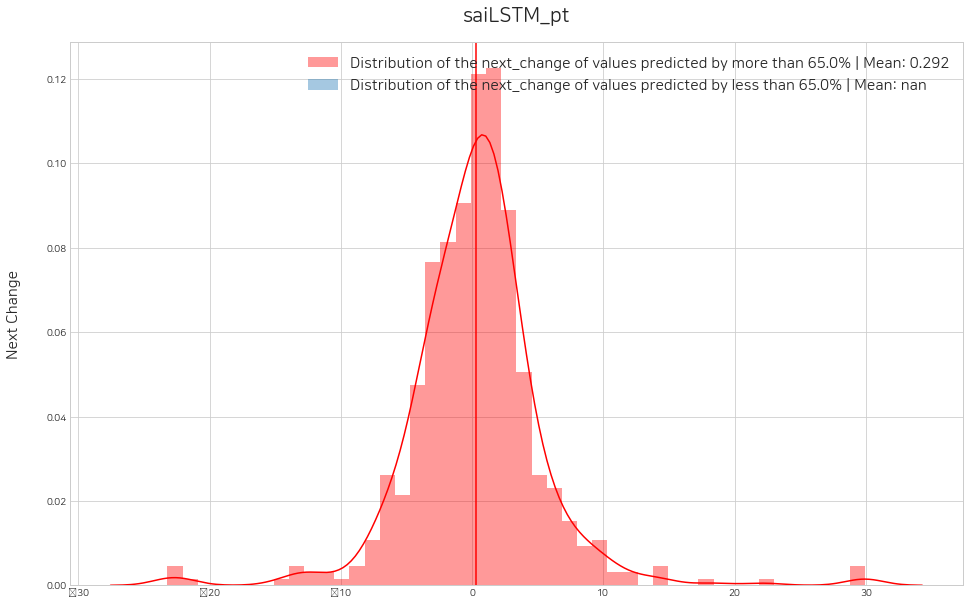

In [20]:
sai.set_threshold(lst_trader, lst_threshold=[0.65], histogram=True)

<br> 
<br> 

# **4. Back-Testing**

## **1) Making a sales log**
#### 각각의 트레이더로, 모든 날짜에 대한 매수, 매도 기록을 생성한 매매일지를 df_signal_all에 넣어준다.  

In [2]:
df_signal_all = sai.decision(lst_trader, dtype='test')
df_signal_all

<br> 

## **2) Simulation: Calculate the yield**
#### 위에서 구한 매매일지 **df_signal_all**을 토대로 각 트레이더에 대한 수익률을 계산한다. 
#### `init_budget` 인자에 초기 예산을 입력하고, `fee` 인자에 수수료를 넣어준다. 

In [32]:
df_history_all = sai.simulation(df_signal_all, init_budget=10000000, init_stock={}, fee=0.01)
df_history_all

100%|███████████████████████████████████████████████████████████████████████████▋| 247/248 [00:35<00:00,  6.94it/s]


== saiLSTM_tf completed ==


,Trader_id,Sell_date,Budget,Yield,Stock
0,saiLSTM_tf,2021-01-04,10000000,0.000000,{}
1,saiLSTM_tf,2021-01-05,9868025,-1.319748,"{'001120': 41, '002840': 8, '003550': 12, '004..."
2,saiLSTM_tf,2021-01-06,9440312,-5.596873,"{'004020': 75, '079430': 195, '097950': 7}"
3,saiLSTM_tf,2021-01-07,9215016,-7.849838,"{'034300': 157, '145720': 107}"
4,saiLSTM_tf,2021-01-08,9294533,-7.054663,"{'004360': 61, '004430': 43, '006260': 9, '006..."
...,...,...,...,...,...
243,saiLSTM_tf,2021-12-24,222228,-97.777719,"{'001460': 0, '002420': 4, '003580': 2, '11758..."
244,saiLSTM_tf,2021-12-27,221007,-97.789923,"{'000860': 3, '064960': 1, '092200': 13}"
245,saiLSTM_tf,2021-12-28,204320,-97.956797,"{'002620': 4, '003580': 3, '084870': 32}"
246,saiLSTM_tf,2021-12-29,203375,-97.966242,"{'002310': 1, '018470': 35, '138490': 5}"


<br> 

## **3) Leader Board**
#### 트레이더의 수익률 결과를 내림차순으로 정렬하여 데이터프레임 형태의 리더보드를 볼 수 있다. 
#### 결과는 ~~ 와 같이 나왔다. 

In [33]:
sai.leaderboard(df_history_all)

,Trader_id,Yield
0,saiLSTM_tf,-97.972629


<br> 

## **4) Visualize Results**
#### 트레이더 별로 모든 날짜에 대한 수익률 시각화를 볼 수 있다. 

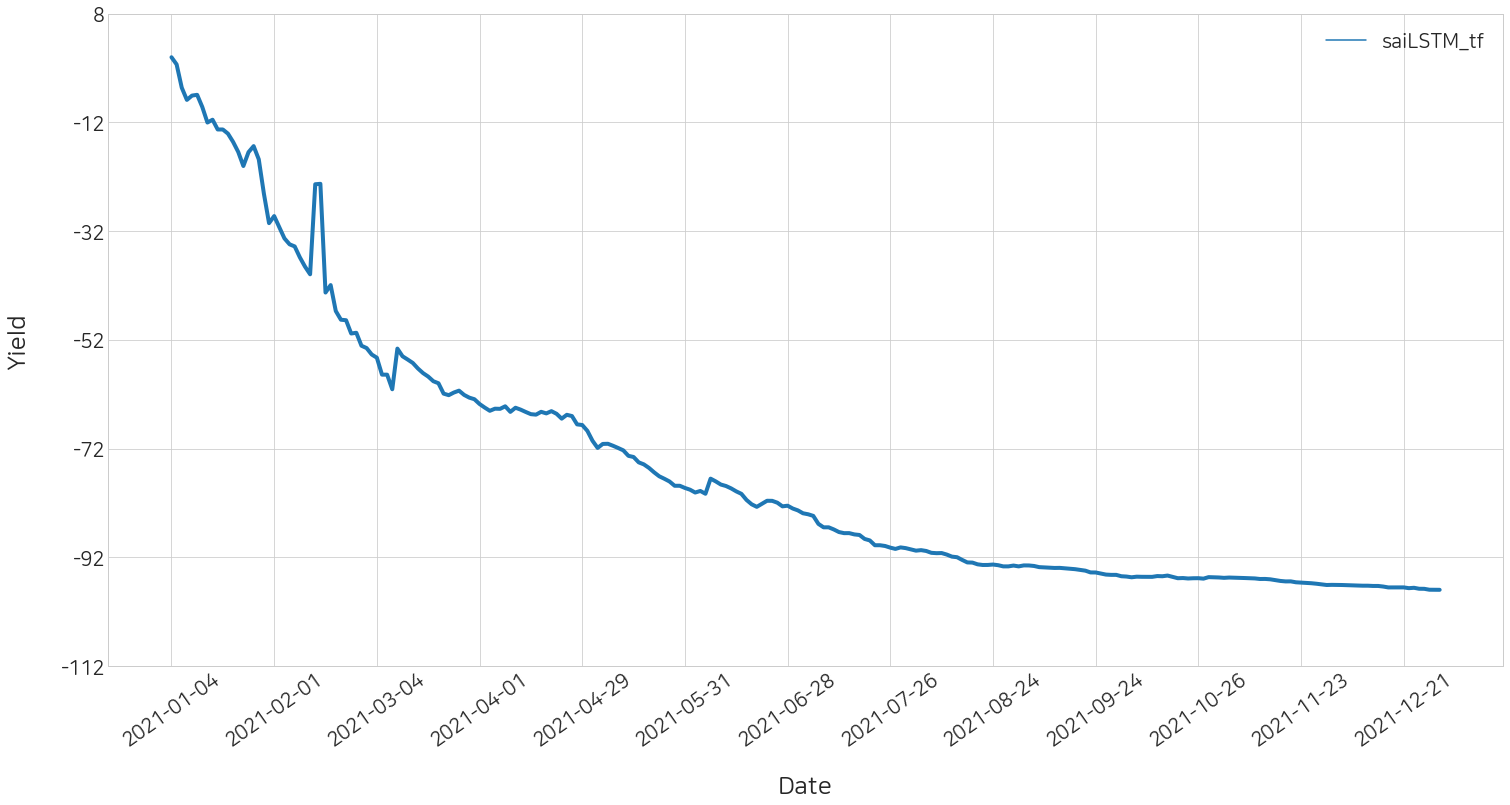

In [34]:
sai.yield_plot(df_history_all)

#### 결과는 ~~ 이렇다 